In [2]:
import numpy as np

### Creating your own GRN

# Generate the cell lineage first

In [87]:
import random
import time

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def get_adjacency_matrix(G):
    return nx.to_numpy_array(G, dtype=int)

def generate_random_cell_cycle(total_nodes=None,
                               min_per_rank=2,
                               max_per_rank=3,
                               min_ranks=1,
                               max_ranks=5,
                               percent=0,
                               master_regulators=0):
    random.seed(time.time())
    G = nx.DiGraph()

    if total_nodes is not None:
        all_indices = list(range(total_nodes))
        if master_regulators is None:
            master_regulators = 1
        mr_indices = sorted(random.sample(all_indices, master_regulators))
        dag_indices = [i for i in all_indices if i not in mr_indices]

        G.add_nodes_from(dag_indices)
        for i in range(1, len(dag_indices)):
            src = random.randint(0, i - 1)
            G.add_edge(dag_indices[src], dag_indices[i])
            for j in range(i):
                if random.randint(0, 99) < percent:
                    G.add_edge(dag_indices[j], dag_indices[i])
        return G, mr_indices

    nodes = 0
    ranks = random.randint(min_ranks, max_ranks)
    all_ranks = []
    for _ in range(ranks):
        new_nodes = random.randint(min_per_rank, max_per_rank)
        current_rank = list(range(nodes, nodes + new_nodes))
        G.add_nodes_from(current_rank)

        if all_ranks:
            prev = all_ranks[-1]
            for n in current_rank:
                G.add_edge(random.choice(prev), n)
        else:
            for i in range(len(current_rank) - 1):
                G.add_edge(current_rank[i], current_rank[i + 1])

        for j in range(nodes):
            for n in current_rank:
                if random.randint(0, 99) < percent:
                    G.add_edge(j, n)

        nodes += new_nodes
        all_ranks.append(current_rank)

    return G, []

def visualize_dag(G, interactions=None):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_labels(G, pos, font_size=10)

    if interactions is None:
        nx.draw_networkx_edges(
            G, pos, edge_color='gray',
            arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5
        )
    else:
        edge_list = [(a, t) for (t, _, a, _, _) in interactions]
        edge_colors = ['red' if mag < 0 else 'green' for (_, _, _, mag, _) in interactions]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=edge_list, edge_color=edge_colors,
            arrows=True, arrowstyle='-|>', arrowsize=20, width=2
        )

    plt.title("Randomly Generated DAG")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
    perturbed = matrix.astype(float).copy()
    ones = np.where(matrix == 1)
    for i, j in zip(*ones):
        perturbed[i][j] = round(random.uniform(min_val, max_val), 1)
    return perturbed

def find_isolated_nodes(G):
    return [n for n in G.nodes()
            if G.in_degree(n) == 0 and G.out_degree(n) == 0]

def generate_interactions_from_dag(G,
                                   scalar=2.0,
                                   mag_range=(0.5, 5.0),
                                   inhibit_pct=50):
    interactions = []
    for u, v in G.edges():
        mag = round(random.uniform(*mag_range), 2)
        mag = -abs(mag) if random.randint(1, 100) <= inhibit_pct else abs(mag)
        interactions.append((v, 1, u, mag, scalar))
    return interactions

def generate_master_regulator_profiles(mr_indices, num_celltypes=3):
    """
    Return a list of strings: [f"{id},{val1},{val2},..."] per master regulator.
    Values should be different across types to reflect their role.
    """
    profiles = []
    for idx in mr_indices:
        values = [round(random.uniform(0.0, 4.0), 4) for _ in range(num_celltypes)]
        profiles.append(f"{idx}," + ",".join(map(str, values)))
    return profiles

def main(mode,
         total_nodes=None,
         min_per_rank=2,
         max_per_rank=3,
         min_ranks=1,
         max_ranks=5,
         percent=0,
         inhibit_pct=50,
         master_regulators=None,
         num_celltypes=3):
    """
    mode: 'cell' → output adjacency + perturbed matrices
          'gene' → output gene interactions and master regulator profiles
    """
    dag, mr_indices = generate_random_cell_cycle(
        total_nodes,
        min_per_rank,
        max_per_rank,
        min_ranks,
        max_ranks,
        percent,
        master_regulators
    )

    interactions = generate_interactions_from_dag(dag, inhibit_pct=inhibit_pct)
    visualize_dag(dag, interactions if mode == 'gene' else None)

    iso = find_isolated_nodes(dag)
    print("Isolated Nodes:", iso)

    if mode == 'cell':
        matrix = get_adjacency_matrix(dag)
        print("\nAdjacency Matrix:\n", matrix)

        perturbed = perturb_adjacency_matrix(matrix)
        print("\nPerturbed Adjacency Matrix:\n", perturbed)

        with open("perturbed_matrix.tab", "w") as f:
            for row in perturbed:
                f.write("\t".join(map(str, row)) + "\n")
        print("\nPerturbed matrix written to perturbed_matrix.tab")

    elif mode == 'gene':
        print("\nGenerated Gene Regulatory Interactions:")
        print("(target, type, affector, magnitude, scalar)")
        for inter in interactions:
            print(inter)

        if mr_indices:
            print("\nMaster Regulator Profiles (by cell type):")
            profiles = generate_master_regulator_profiles(mr_indices, num_celltypes)
            for p in profiles:
                print(p)

    else:
        raise ValueError("Mode must be 'cell' or 'gene'")

# Example usage
# main('gene', total_nodes=10, master_regulators=2, inhibit_pct=50, num_celltypes=3)


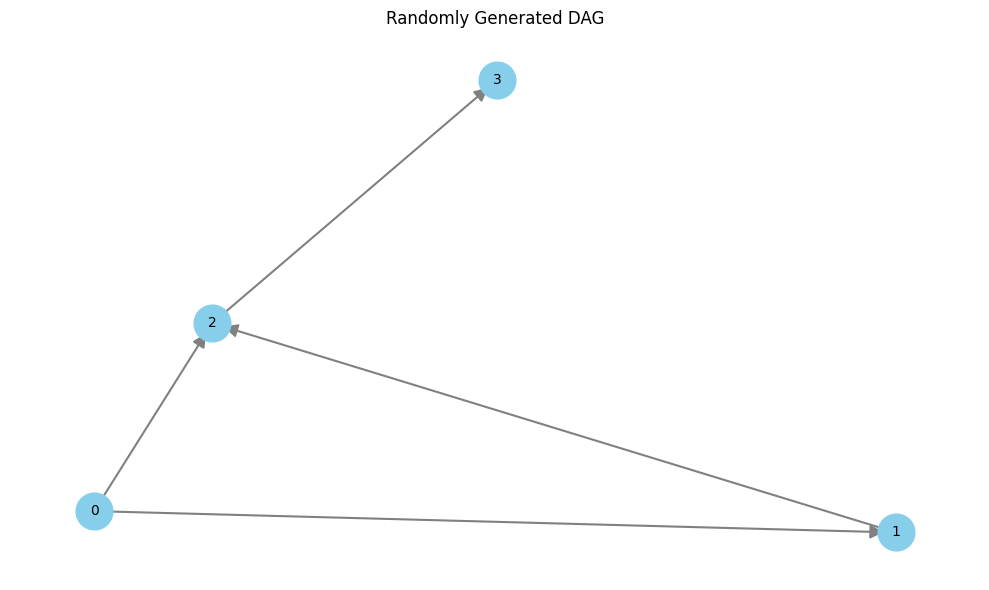

Isolated Nodes: []

Adjacency Matrix:
 [[0 1 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]

Perturbed Adjacency Matrix:
 [[0.  1.  0.9 0. ]
 [0.  0.  0.9 0. ]
 [0.  0.  0.  0.9]
 [0.  0.  0.  0. ]]

Perturbed matrix written to perturbed_matrix.tab


In [88]:
# import this module, then:
main('cell', total_nodes=5, min_per_rank=1, max_per_rank=4, min_ranks=1, max_ranks=3, percent=10)


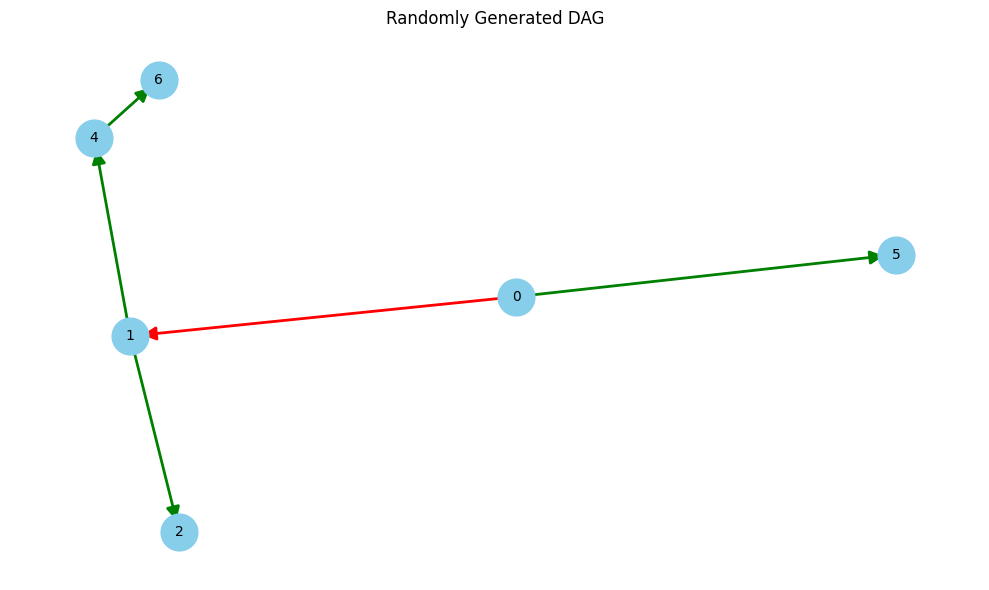

Isolated Nodes: []

Generated Gene Regulatory Interactions:
(target, type, affector, magnitude, scalar)
(1, 1, 0, -1.41, 2.0)
(5, 1, 0, 2.59, 2.0)
(2, 1, 1, 3.96, 2.0)
(4, 1, 1, 1.87, 2.0)
(6, 1, 4, 0.57, 2.0)

Master Regulator Profiles (by cell type):
3,2.5468,3.5985,2.0359


In [90]:
main('gene', total_nodes=7, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=2, percent=5, inhibit_pct=30, master_regulators=1)